In [ ]:
'''
코랩 런타임 유지
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect, 1800000)
'''

'\n코랩 런타임 유지\nfunction ClickConnect(){\nconsole.log("Working");\ndocument.querySelector("colab-toolbar-button#connect").click()\n}setInterval(ClickConnect, 1800000)\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import json
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.notebook import tqdm

##전처리##

In [ ]:
import json

input_file_path = '/content/drive/MyDrive/dataexp_final/challenger_match_infos.json'

with open(input_file_path, 'r') as json_file:
    challenger_match_infos = json.load(json_file)

print(f"Loaded {len(challenger_match_infos)} match infos.")

Loaded 1980 match infos.


In [ ]:
for each_match in challenger_match_infos[:5]:
    print(each_match['info'].keys())

dict_keys(['endOfGameResult', 'gameCreation', 'gameId', 'game_datetime', 'game_length', 'game_version', 'mapId', 'participants', 'queueId', 'queue_id', 'tft_game_type', 'tft_set_core_name', 'tft_set_number'])
dict_keys(['endOfGameResult', 'gameCreation', 'gameId', 'game_datetime', 'game_length', 'game_version', 'mapId', 'participants', 'queueId', 'queue_id', 'tft_game_type', 'tft_set_core_name', 'tft_set_number'])
dict_keys(['endOfGameResult', 'gameCreation', 'gameId', 'game_datetime', 'game_length', 'game_version', 'mapId', 'participants', 'queueId', 'queue_id', 'tft_game_type', 'tft_set_core_name', 'tft_set_number'])
dict_keys(['endOfGameResult', 'gameCreation', 'gameId', 'game_datetime', 'game_length', 'game_version', 'mapId', 'participants', 'queueId', 'queue_id', 'tft_game_type', 'tft_set_core_name', 'tft_set_number'])
dict_keys(['endOfGameResult', 'gameCreation', 'gameId', 'game_datetime', 'game_length', 'game_version', 'mapId', 'participants', 'queueId', 'queue_id', 'tft_game_ty

In [ ]:
matches = []
for match in challenger_match_infos:
    if 'info' in match and 'participants' in match['info']:
        for participant in match['info']['participants']:
            data = {
                'placement': participant['placement'],
                'level': participant['level'],
                'gold_left': participant['gold_left'],
                'players_eliminated': participant['players_eliminated'],
                'total_damage_to_players': participant['total_damage_to_players'],
                'augments': '|'.join(participant['augments']),
                'traits': '|'.join([trait['name'] for trait in participant['traits']])
            }
            matches.append(data)

df = pd.DataFrame(matches)

In [ ]:
df.head()

,placement,level,gold_left,players_eliminated,total_damage_to_players,augments,traits
0,2,9,9,3,153,TFT10_Augment_FullyAdapted|TFT6_Augment_Pandor...,TFT11_Arcanist|TFT11_Behemoth|TFT11_Bruiser|TF...
1,8,8,0,0,84,TFT11_Augment_ReaperCrest|TFT7_Augment_BandOfT...,TFT11_Altruist|TFT11_Bruiser|TFT11_Dryad|TFT11...
2,7,8,0,0,99,TFT9_Augment_BardPlaybook2|TFT9_Augment_Missed...,TFT11_Arcanist|TFT11_Dragonlord|TFT11_Fortune|...
3,5,9,3,0,83,TFT6_Augment_Diversify2|TFT9_Augment_MissedCon...,TFT11_Artist|TFT11_Bruiser|TFT11_Dragonlord|TF...
4,3,10,0,1,103,TFT11_Augment_Reaper|TFT6_Augment_TinyTitans|T...,TFT11_Altruist|TFT11_Bruiser|TFT11_Dryad|TFT11...


In [ ]:
df['win'] = df['placement'] <= 4
df = df.drop(columns=['placement'])

df = pd.get_dummies(df, columns=['augments', 'traits'], drop_first=True)

X = df.drop(columns=['win'])
y = df['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SGDClassifier(max_iter=1, tol=None, warm_start=True)
epochs = 500
for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 0.8805858054825385
[[1263   61]
 [ 257 1082]]
              precision    recall  f1-score   support

       False       0.83      0.95      0.89      1324
        True       0.95      0.81      0.87      1339

    accuracy                           0.88      2663
   macro avg       0.89      0.88      0.88      2663
weighted avg       0.89      0.88      0.88      2663



##Experiments(ML/DL)##

###Augments

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_json('/content/drive/MyDrive/dataexp_final/challenger_match_infos.json')
df = df.dropna(subset=['info'])

df_augments = df['info'].apply(lambda x: [p.get('augments', []) for p in x['participants']] if isinstance(x['participants'], list) else np.nan).dropna().explode().apply(pd.Series)
df_augments = df_augments.stack().reset_index(drop=True)

df_augments = pd.get_dummies(df_augments)
df_placement = df['info'].apply(lambda x: [p.get('placement', np.nan) for p in x['participants']] if isinstance(x['participants'], list) else np.nan).dropna().explode().reset_index(drop=True)
df_augments['placement'] = df_placement

df_augments = df_augments.dropna()

X = df_augments.drop(columns=['placement'])
y = df_augments['placement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(n_estimators=5, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5.289821854198275


Mean Squared Error: 5.295414135220142


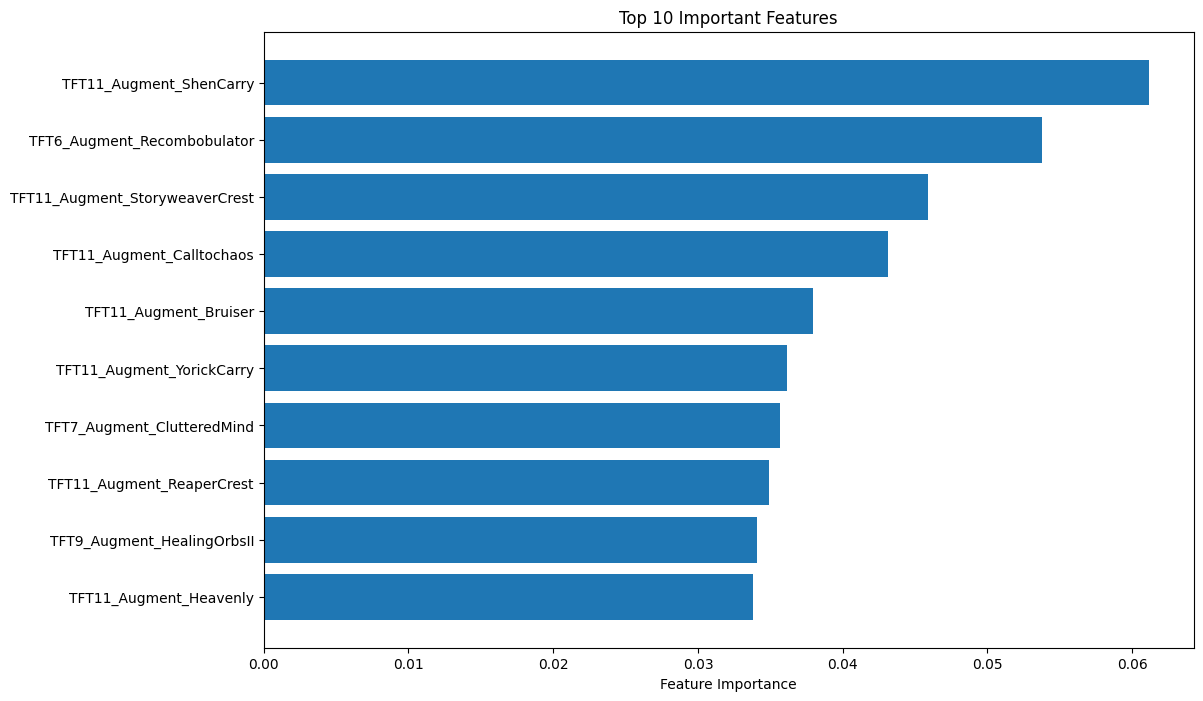

In [ ]:

feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[-10:]  # 상위 10개 중요도 피처

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features')
plt.show()

###Units

Mean Squared Error: 5.285557413205338


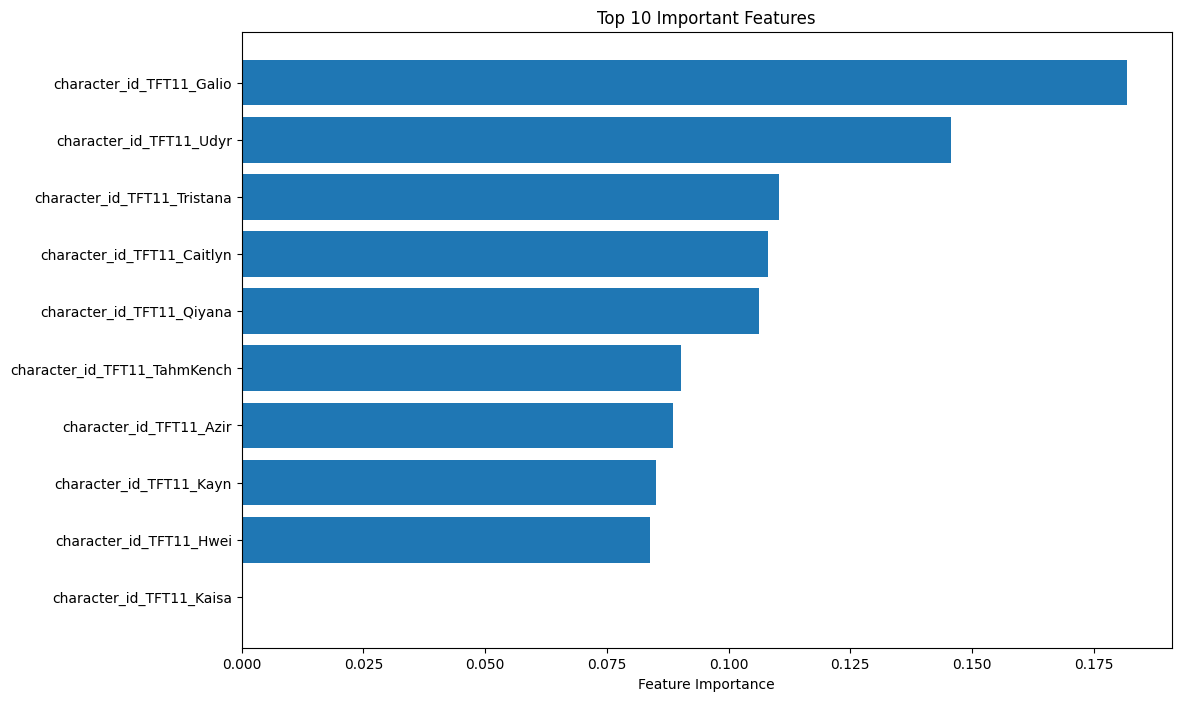

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_json('/content/drive/MyDrive/dataexp_final/challenger_match_infos.json')
df = df.dropna(subset=['info'])

df_units = df['info'].apply(lambda x: [p['units'] for p in x['participants']] if isinstance(x['participants'], list) else np.nan).dropna().explode().reset_index(drop=True)

units_list = []
for i in range(len(df_units)):
    units_list.extend(df_units.iloc[i])

df_units = pd.DataFrame(units_list)

df_units = df_units[['character_id']]

df_units = pd.get_dummies(df_units)

df_placement = df['info'].apply(lambda x: [p.get('placement', np.nan) for p in x['participants']] if isinstance(x['participants'], list) else np.nan).dropna().explode().reset_index(drop=True)

df_units['placement'] = df_placement
df_units = df_units.dropna()

X = df_units.drop(columns=['placement'])
y = df_units['placement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=5, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[-10:]
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features')
plt.show()


###Traits

Mean Squared Error: 5.289546500072595


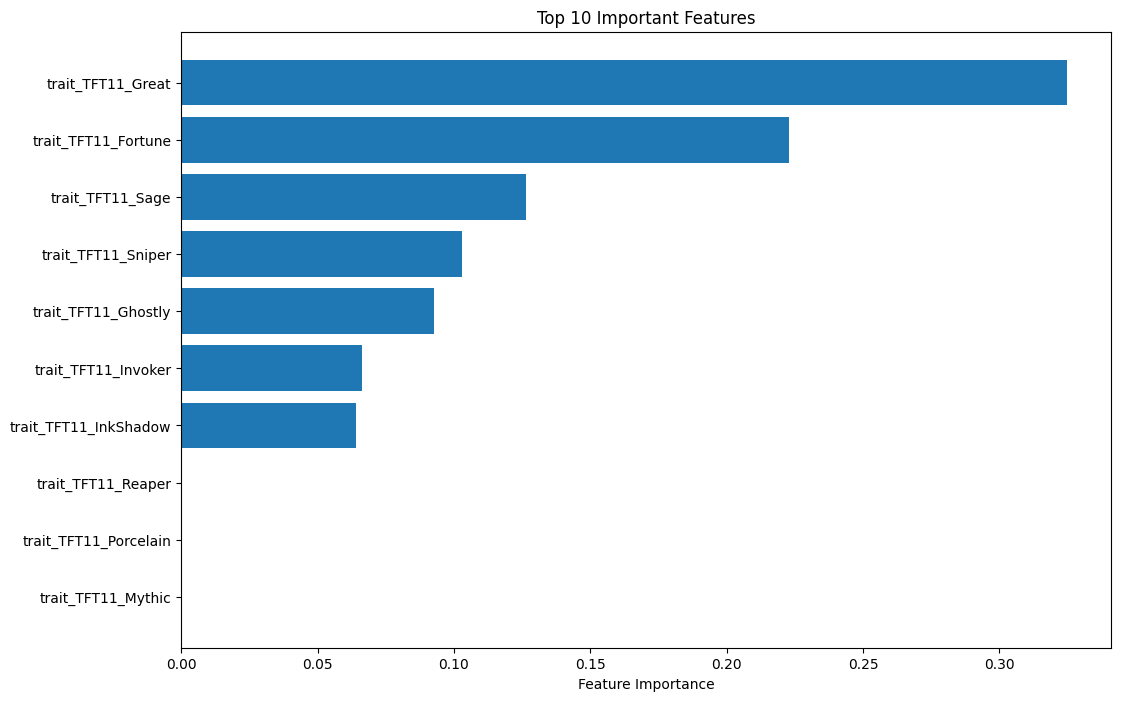

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_json('/content/drive/MyDrive/dataexp_final/challenger_match_infos.json')
df = df.dropna(subset=['info'])

df_traits = df['info'].apply(lambda x: [p['traits'] for p in x['participants']] if isinstance(x['participants'], list) else np.nan).dropna().explode().reset_index(drop=True)

traits_list = []
for i in range(len(df_traits)):
    traits_list.extend(df_traits.iloc[i])

df_traits = pd.DataFrame(traits_list)
df_traits = df_traits[['name']]

df_traits = pd.get_dummies(df_traits, prefix='trait')

df_placement = df['info'].apply(lambda x: [p.get('placement', np.nan) for p in x['participants']] if isinstance(x['participants'], list) else np.nan).dropna().explode().reset_index(drop=True)

df_traits['placement'] = df_placement
df_traits = df_traits.dropna()

X = df_traits.drop(columns=['placement'])
y = df_traits['placement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=5, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[-10:]

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features')
plt.show()


###DL) TFTNet & Hybrid loss

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def hybrid_loss(predicted, actual, alpha=0.5):
    mse_loss = nn.MSELoss()(predicted, actual)

    pairwise_diff = torch.matmul(predicted - predicted.t(), actual - actual.t())
    pairwise_loss = torch.mean(torch.clamp(-pairwise_diff, min=0))

    return alpha * mse_loss + (1 - alpha) * pairwise_loss

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

df = pd.read_json('/content/drive/MyDrive/dataexp_final/challenger_match_infos.json')
df = df.dropna(subset=['info'])

df_augments = df['info'].apply(lambda x: [p.get('augments', []) for p in x['participants']] if isinstance(x['participants'], list) else np.nan).dropna().explode().apply(pd.Series)
df_augments = df_augments.stack().reset_index(drop=True)
df_augments = pd.get_dummies(df_augments)

df_placement = df['info'].apply(lambda x: [p.get('placement', np.nan) for p in x['participants']] if isinstance(x['participants'], list) else np.nan).dropna().explode().reset_index(drop=True)

df_augments['placement'] = df_placement
df_augments = df_augments.dropna()

X = df_augments.drop(columns=['placement'])
y = df_augments['placement']

y = pd.to_numeric(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) * 8
        return x

def hybrid_loss(predicted, actual, alpha=0.5):
    mse_loss = nn.MSELoss()(predicted, actual)

    pairwise_diff = torch.matmul(predicted - predicted.t(), actual - actual.t())
    pairwise_loss = torch.mean(torch.clamp(-pairwise_diff, min=0))

    return alpha * mse_loss + (1 - alpha) * pairwise_loss

input_size = X_train.shape[1]
model = SimpleNN(input_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

In [ ]:
epochs = 100
for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = hybrid_loss(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = hybrid_loss(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')

predicted_placements = predictions.cpu().numpy().flatten()
actual_placements = y_test_tensor.cpu().numpy().flatten()
input_augments = X_test_tensor.cpu().numpy()

augment_names = X.columns

results = pd.DataFrame(input_augments, columns=augment_names)
results['Actual Placement'] = actual_placements
results['Predicted Placement'] = predicted_placements

print(results.head())

Test Loss: 8.75144100189209
   TFT10_Augment_BigGains  TFT10_Augment_CrashTestDummies  \
0               -0.021674                       -0.064413   
1               -0.021674                       -0.064413   
2               -0.021674                       -0.064413   
3               -0.021674                       -0.064413   
4               -0.021674                       -0.064413   

   TFT10_Augment_CrownGuarded  TFT10_Augment_FullyAdapted  \
0                   -0.049472                   -0.048509   
1                   -0.049472                   -0.048509   
2                   -0.049472                   -0.048509   
3                   -0.049472                   -0.048509   
4                   -0.049472                   -0.048509   

   TFT10_Augment_GoingLong  TFT10_Augment_GoodForSomethingSilver  \
0                -0.023743                             -0.025647   
1                -0.023743                             -0.025647   
2                -0.023743        